# Smoothing Spline

## Load Data

In [1]:
import numpy as np
from sklearn.datasets import load_boston

In [2]:
X = load_boston().data[:, 12]
y = load_boston().target

In [3]:
import matplotlib.pyplot as plt

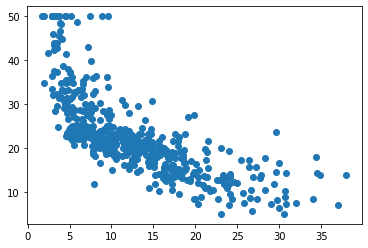

In [4]:
fig, ax = plt.subplots()
ax.scatter(X, y)
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

---

## My Smoothing Spline

In [7]:
class MySmoothingSpline:
    def __init__(self, alpha=1):
        self.alpha = alpha
        
    def fit(self, X_train, y_train):
        self.X_train = np.array(X_train)
        y_train = np.array(y_train)
        X_train_new = np.column_stack((np.ones(len(self.X_train)), self.X_train))
        d_Km1 = (np.where(np.power(self.X_train-self.X_train[-2], 3) < 0, 0, np.power(self.X_train-self.X_train[-2], 3))-np.where(np.power(self.X_train-self.X_train[-1], 3) < 0, 0, np.power(self.X_train-self.X_train[-1], 3)))/(self.X_train[-2]-self.X_train[-1])
        for i in range(len(self.X_train)-2):
            d = (np.where(np.power(self.X_train-self.X_train[i], 3) < 0, 0, np.power(self.X_train-self.X_train[i], 3))-np.where(np.power(self.X_train-self.X_train[-1], 3) < 0, 0, np.power(self.X_train-self.X_train[-1], 3)))/(self.X_train[i]-self.X_train[-1])
            X_train_new = np.column_stack((X_train_new, d-d_Km1))
        delta = np.zeros((len(self.X_train)-2, len(self.X_train)))
        for i in range(len(self.X_train)-2):
            delta[i, i] = 1/(self.X_train[i+1]-self.X_train[i])
            delta[i, i+1] = -1/(self.X_train[i+1]-self.X_train[i])-1/(self.X_train[i+2]-self.X_train[i+1])
            delta[i, i+2] = 1/(self.X_train[i+2]-self.X_train[i+1])
        W = np.zeros((len(self.X_train)-2, len(self.X_train)-2))
        for i in range(1, len(self.X_train)-2):
            W[i-1, i] = W[i, i-1] = (self.X_train[i+1]-self.X_train[i])/6
            W[i, i] = (self.X_train[i+2]-self.X_train[i])/3
        omega = np.transpose(delta).dot(np.linalg.inv(W)).dot(delta)
        self.beta = np.linalg.inv(np.transpose(X_train_new).dot(X_train_new)+self.alpha*omega).dot(np.transpose(X_train_new)).dot(y_train)
    
    def predict(self, X_test):
        X_test = np.array(X_test)
        X_test_new = np.column_stack((np.ones(len(X_test)), X_test))
        d_Km1 = (np.where(np.power(X_test-self.X_train[-2], 3) < 0, 0, np.power(X_test-self.X_train[-2], 3))-np.where(np.power(X_test-self.X_train[-1], 3) < 0, 0, np.power(X_test-self.X_train[-1], 3)))/(self.X_train[-2]-self.X_train[-1])
        for i in range(len(self.X_train)-2):
            d = (np.where(np.power(X_test-self.X_train[i], 3) < 0, 0, np.power(X_test-self.X_train[i], 3))-np.where(np.power(X_test-self.X_train[-1], 3) < 0, 0, np.power(X_test-self.X_train[-1], 3)))/(self.X_train[i]-self.X_train[-1])
            X_test_new = np.column_stack((X_test_new, d-d_Km1))
        return X_test_new.dot(self.beta)

In [8]:
model = MySmoothingSpline()

In [9]:
model.fit(X_train, y_train)

In [10]:
y_pred = model.predict(X_test)

In [11]:
from sklearn.metrics import mean_squared_error as mse

In [12]:
print('MSE of My SmoothingSpline:', mse(y_test, y_pred))

MSE of My SmoothingSpline: 34.03650107824669


---

## Compare to Scikit-Learn

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [14]:
model = LinearRegression()

In [15]:
X_train = X_train.reshape(-1, 1)

In [16]:
model.fit(PolynomialFeatures(degree=2).fit_transform(X_train), y_train)

LinearRegression()

In [17]:
X_test = X_test.reshape(-1, 1)

In [18]:
y_pred = model.predict(PolynomialFeatures(degree=2).fit_transform(X_test))

In [19]:
print('MSE of sklearn PolynomialRegression:', mse(y_test, y_pred))

MSE of sklearn PolynomialRegression: 33.60239474228597
